# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Grid search for hyperparameter settings
This notebook shows a selection of grid searches and randomized grid searches done for with the PINN-implementation based on ...


### Notebook initial imports and defaults

In [1]:
from networkFlowTorch import *
from PDEq import *
from support import *

import autograd.numpy as anp
import numpy as np
from math import log10

import matplotlib.pyplot as plt

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (10,4); plt.rcParams["font.size"] = 10
cmap = 'hot_r'; bin_vals = 7

## --- Network initial defaults --- ##
## Collocation tensor parameters
c_points = 1000; b_points = 20; i_points = 20

## Activation function
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

## Layer configuration
l_size = 20; 
layer_out_sizes = [20,20,1]

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Training parameters
epoch = 1000
gd_method = 'adam'

## --- Search parameters --- ##
num = 6
rand_num = 6

## --- Problem setup --- ##
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

2024-12-12 10:00:04.780852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 10:00:04.792874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733994004.807023   65076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733994004.812684   65076 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:00:04.826927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Regular grid search 
### Learning rate, $\eta$, vs. regularization, $\lambda$
A grid search comparing the learning rate and regularization of the parameters of the network. Here, gradient descent is performed using the `Adagrad`-method.

In [2]:
## Training parameters
eta = np.logspace(-3,-1,num)
lmbda = np.logspace(-9,-7,num)

cost = np.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Network initializtion
        if test == 'wave2d' or test == 'diff2d':
            TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
        else:
            TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

        TFNetwork.create_layers(lmbda=lmbda[j])

        print('η,λ = %.2e, %.2e' %(eta[i],lmbda[j]))
        TFNetwork.train_network(epochs=epoch)

        cost[i,j] = TFNetwork.cost_history[-1]

η,λ = 1.00e-03, 1.00e-09
Final cost = 8.28574e-03
η,λ = 1.00e-03, 2.51e-09
Final cost = 8.22994e-03
η,λ = 1.00e-03, 6.31e-09
Final cost = 7.34998e-03
η,λ = 1.00e-03, 1.58e-08
Final cost = 9.03074e-03
η,λ = 1.00e-03, 3.98e-08
Final cost = 8.37635e-03
η,λ = 1.00e-03, 1.00e-07
Final cost = 8.31537e-03
η,λ = 2.51e-03, 1.00e-09
Final cost = 4.53404e-03
η,λ = 2.51e-03, 2.51e-09
Final cost = 5.84355e-03
η,λ = 2.51e-03, 6.31e-09
Final cost = 6.34024e-03
η,λ = 2.51e-03, 1.58e-08
Final cost = 5.55568e-03
η,λ = 2.51e-03, 3.98e-08
Final cost = 6.29017e-03
η,λ = 2.51e-03, 1.00e-07
Final cost = 6.18370e-03
η,λ = 6.31e-03, 1.00e-09
Final cost = 6.51453e-03
η,λ = 6.31e-03, 2.51e-09
Final cost = 5.65242e-03
η,λ = 6.31e-03, 6.31e-09
Final cost = 5.10138e-03
η,λ = 6.31e-03, 1.58e-08
Final cost = 5.80925e-03
η,λ = 6.31e-03, 3.98e-08
Final cost = 5.35118e-03
η,λ = 6.31e-03, 1.00e-07
Final cost = 6.14019e-03
η,λ = 1.58e-02, 1.00e-09
Final cost = 4.56632e-03
η,λ = 1.58e-02, 2.51e-09
Final cost = 5.53938e-03


Min cost for:
η = 1.000e-01
λ = 1.585e-08
Final cost = 3.81306e-03


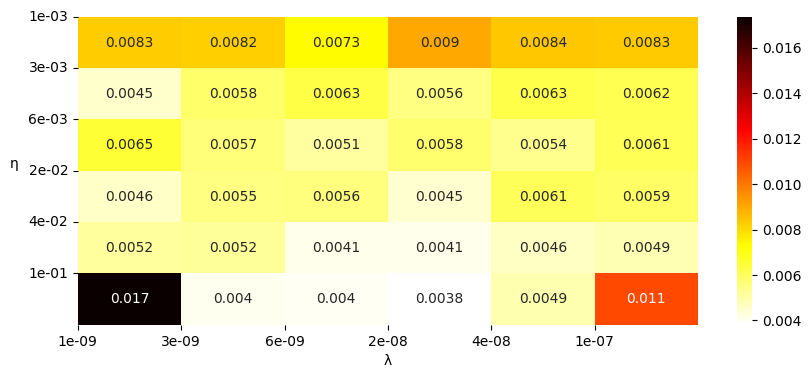

In [3]:
fig,ax = lambda_eta(cost,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[cost.min(),cost.max()],cmap=cmap
                    )

fig.set_size_inches(10,4)

min_cost_idx = np.argmin(cost); min_cost_pos = np.unravel_index(min_cost_idx, cost.shape)

print('Min cost for:\nη = %.3e\nλ = %.3e'%(eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))
print('Final cost = %.5e' %cost[min_cost_pos])

## Randomized grid searchs
The following part performs a randomized grid search for the optimal hyperparameters for the chosen PDE-problem. 

It does searches of random combinations of learning rate, $\eta$, regularization, $\lambda$, epochs, $e$, network depth, $d$, and hidden layer width, $M$. 

The ranges currently set up in the cells below are ranges that was found to give good results for the chosen PDE-problem.
### Search: Learning rate, $\eta$, vs. regularization, $\lambda$

In [4]:
## Search parameters
eta_range = [1e-3,1e-1]
lmbda_range = [1e-9,1e-7]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
lmbdas = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking parameters from uniform distribution
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    lmbda = 10 ** np.random.uniform(log10(lmbda_range[0]), log10(lmbda_range[1])); lmbdas[i] = lmbda
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, λ = %.2e, %.2e' %(eta,lmbda))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, λ = 5.50e-03, 2.86e-08
Final cost = 5.97627e-03
η, λ = 4.39e-02, 5.18e-08
Final cost = 6.83417e-03
η, λ = 4.50e-02, 2.45e-08
Final cost = 7.28129e-03
η, λ = 6.04e-03, 6.49e-09
Final cost = 5.11310e-03
η, λ = 2.13e-02, 2.92e-08
Final cost = 6.03212e-03
η, λ = 2.13e-03, 9.27e-09
Final cost = 4.81786e-03


Min cost for:
η = 2.128e-03
λ = 9.270e-09
Final cost = 4.81786e-03


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:392: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


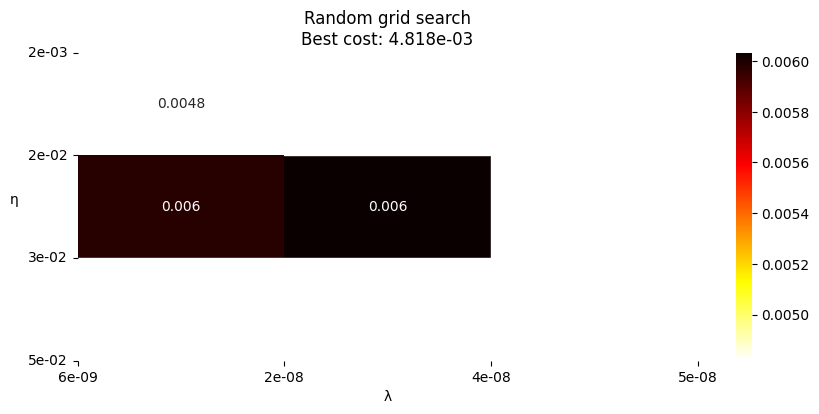

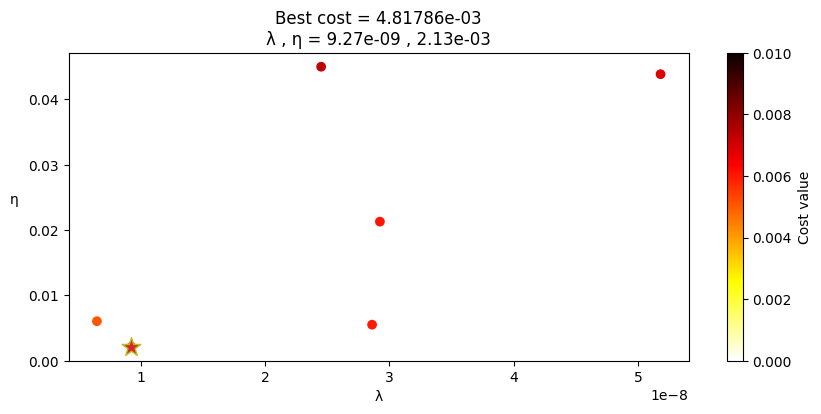

In [5]:
fig_h,ax_h = rand_heatmap(cost,[lmbdas,etas],
             axis_tick_labels='scientific',axis_labels=['λ','η'],
             bin_vals=4,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[lmbdas,etas],axis_labels=['λ','η'],cmap=cmap,cbar_lim=[0.,0.01])

fig_h.set_size_inches(10,4)
fig_s.set_size_inches(10,4) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nλ = %.3e'%(etas[min_cost_idx],lmbdas[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Network depth, $d$, vs. hidden layer size, $M$ 

In [11]:
## Restating training parameters
eta = 1e-2
lmbda = 1e-8

## Search parameters
d_range = [1,6]
M_range = [1,50]

cost = np.zeros(rand_num)
d = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Setting random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('d, M = %i, %i' %(num_lay,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

d, M = 4, 40
Final cost = 4.89026e-03
d, M = 5, 14
Final cost = 6.06311e-03


Min cost for:
d = 4.000000
M = 40.000000
Final cost = 4.89026e-03


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:363: RuntimeWarning: All-NaN slice encountered
  cbar_lim = [np.nanmin(grid_data),np.nanmax(grid_data)]
/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


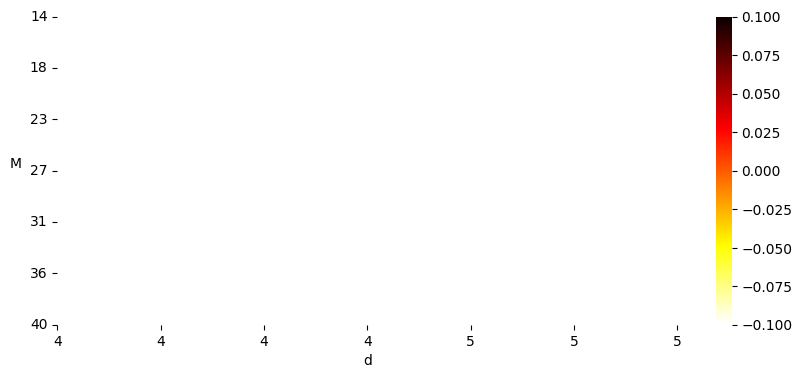

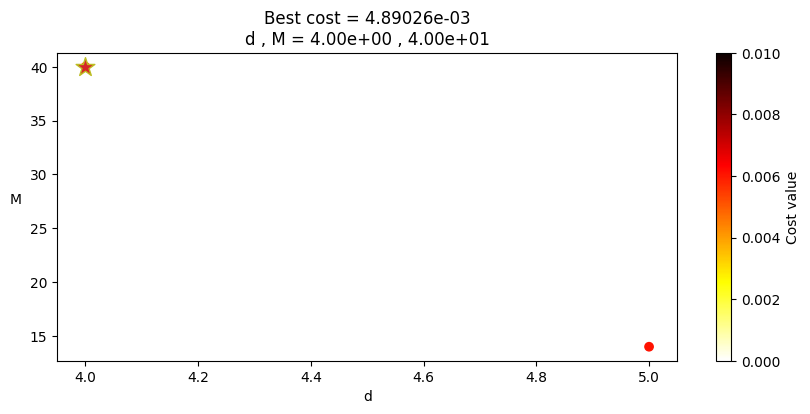

In [12]:
fig_h,ax_h = rand_heatmap(cost,[d,M],
             axis_tick_labels='float',axis_labels=['d','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[d,M],axis_labels=['d','M'],cmap=cmap,cbar_lim=[0.,0.01])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4) 

min_cost_idx = cost.argmin()
print('Min cost for:\nd = %f\nM = %f'%(d[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$, vs. number of epochs, $e$

In [13]:
## Restating network structure parameters
layer_out_sizes = [20,20,1]
act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)
act_funcs.append(None)

## Search parameters
eta_range = [1e-3,1e-1]
epoch_range = [10,4000]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
epochs = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking random parameters
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    epoch = np.random.randint(epoch_range[0],epoch_range[1]); epochs[i] = epoch
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, e = %.3e, %i' %(eta,epoch))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, e = 2.160e-03, 834
Final cost = 8.27957e-03
η, e = 1.199e-03, 937
Final cost = 7.78983e-03


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:363: RuntimeWarning: All-NaN slice encountered
  cbar_lim = [np.nanmin(grid_data),np.nanmax(grid_data)]
/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 1.199e-03
e = 937
Final cost = 7.78983e-03


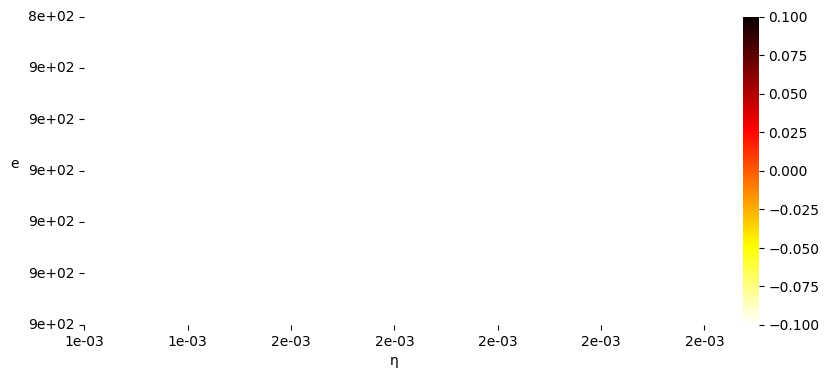

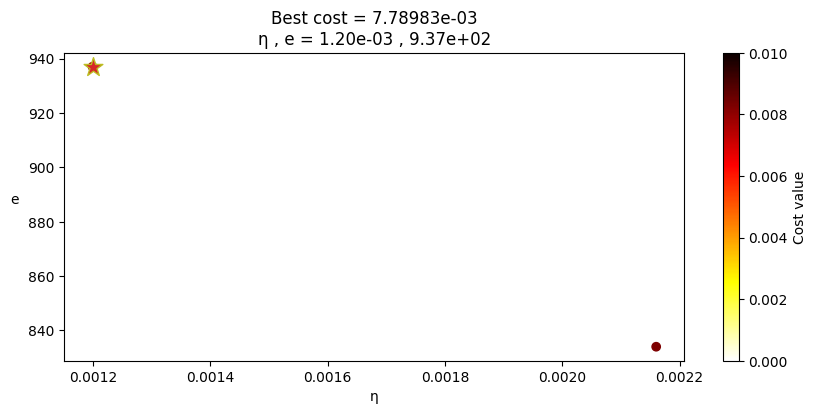

In [14]:
fig_h,ax_h = rand_heatmap(cost,[etas,epochs],
             axis_tick_labels='scientific',axis_labels=['η','e'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,epochs],axis_labels=['η','e'],cbar_lim=[0.,0.01],cmap=cmap)

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\ne = %i'%(etas[min_cost_idx],epochs[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$ vs., network depth, $d$

In [15]:
## Restating training parameters
epoch = 1000

## Search parameters
eta_range = [1e-3,1e-1]
d_range = [1,6]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
d = np.zeros(rand_num)

for i in range(rand_num):
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta

    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, d = %.3e, %i' %(eta,num_lay))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, d = 9.933e-02, 3
Final cost = 9.29275e-03
η, d = 3.319e-02, 1
Final cost = 4.86880e-03


Min cost for:
η = 3.319e-02
d = 1
Final cost = 4.86880e-03


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


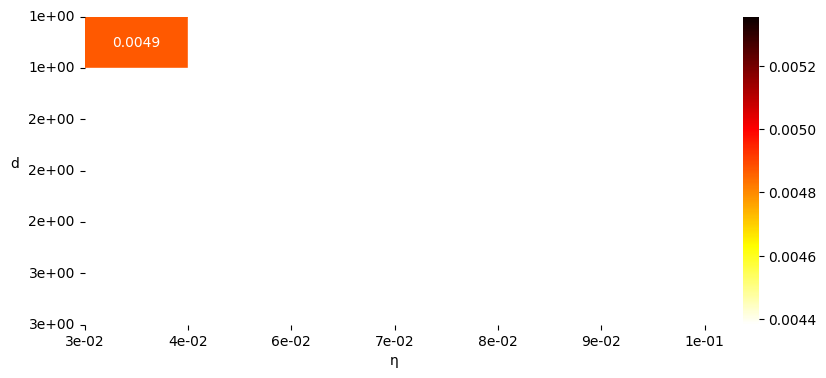

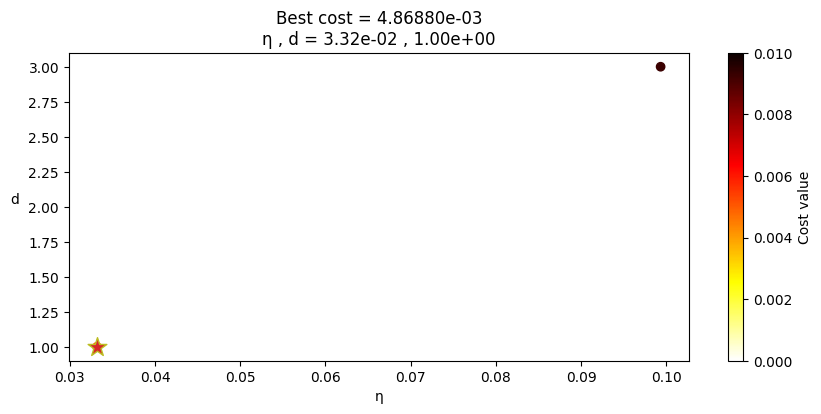

In [16]:
fig_s,ax_s = rand_heatmap(cost,[etas,d],
             axis_tick_labels='scientific',axis_labels=['η','d'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,d],cmap=cmap,cbar_lim=[0.,0.01],axis_labels=['η','d'])

fig_h.set_size_inches(10,4)
fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nd = %i'%(etas[min_cost_idx],d[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])


### Search: Learning rate, $\eta$ vs. hidden layer width, $M$

In [17]:
## Restating network parameters
num_lay = 4

## Search parameters
eta_range = [1e-3,1e-1]
M_range = [1,50]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Picking random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, M = %.3e, %i' %(eta,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, M = 3.526e-03, 7
Final cost = 5.97096e-03
η, M = 9.022e-03, 23
Final cost = 5.55869e-03


Min cost for:
η = 9.022e-03
M = 23
Final cost = 5.55869e-03


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


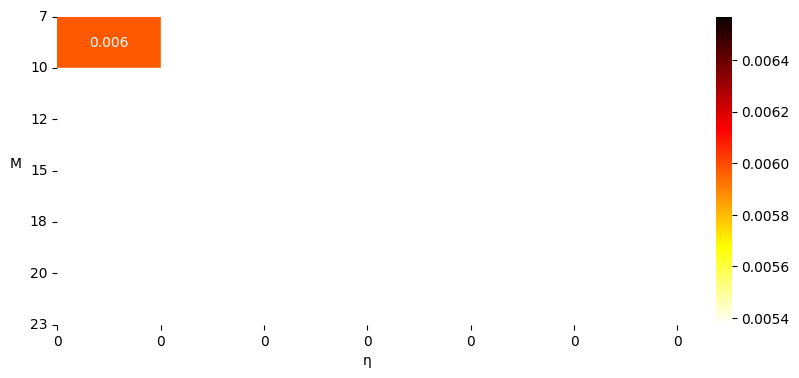

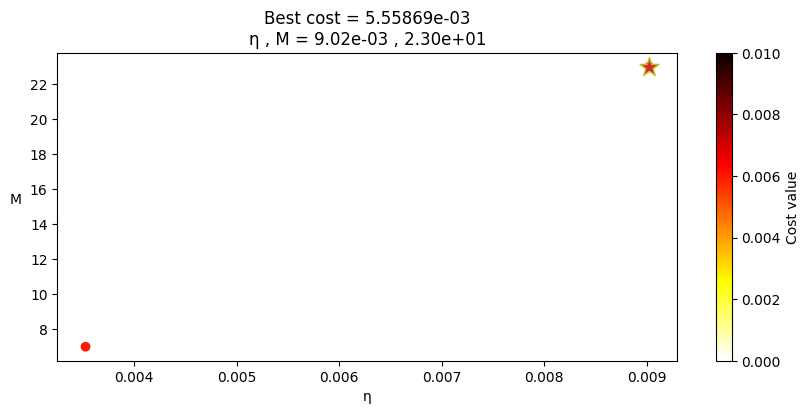

In [18]:
fig_h,ax_h = rand_heatmap(cost,[etas,M],
             axis_tick_labels='float',axis_labels=['η','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,M],cmap=cmap,cbar_lim=[0.,0.01],axis_labels=['η','M'])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nM = %i'%(etas[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])